# Analyzing Sales Data with PySpark and SQL

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Sales Data Analysis").getOrCreate()

In [3]:
sales_df = spark.read.csv("sales.csv", header=True, inferSchema=True)

In [4]:
sales_df.show(5)

+--------+--------------------+-------------------+-----+--------+----------+
|order_id|                name|         ordered_at|price|quantity|line_total|
+--------+--------------------+-------------------+-----+--------+----------+
|   10000|"""ICE CREAM"" Pe...|2018-01-01 11:30:00|$3.50|       3|    $10.50|
|   10000|"""ICE CREAM"" Pe...|2018-01-01 11:30:00|$3.50|       1|     $3.50|
|   10001|"""SORBET"" Raspb...|2018-01-01 12:14:54|$2.50|       2|     $5.00|
|   10001|                NULL|2018-01-01 12:14:54|$1.50|       1|     $1.50|
|   10001|"""CONE"" Dipped ...|2018-01-01 12:14:54|$3.50|       1|     $3.50|
+--------+--------------------+-------------------+-----+--------+----------+
only showing top 5 rows



In [5]:
sales_df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- ordered_at: timestamp (nullable = true)
 |-- price: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- line_total: string (nullable = true)



# Step 2: Filter rows with null values in critical columns
cleaned_df = sales_df.filter(sales_df["name"].isNotNull() & (trim(col("name")) != "NULL") & sales_df["order_id"].isNotNull())

In [6]:
from pyspark.sql.functions import regexp_replace, col, trim, lower

In [7]:
# Step 1 Remove the $
cleaned_df = sales_df.withColumn("clean_price", regexp_replace("price", "\\$", "").cast("double"))
cleaned_df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- ordered_at: timestamp (nullable = true)
 |-- price: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- line_total: string (nullable = true)
 |-- clean_price: double (nullable = true)



In [8]:
from pyspark.sql.functions import col, trim, lower

cleaned_df = cleaned_df.filter(
    col("order_id").isNotNull() &
    col("name").isNotNull() &
    (trim(lower(col("name"))) != "null") &
    (trim(col("name")) != "")
)

In [9]:
cleaned_df.show()

+--------+--------------------+-------------------+-----+--------+----------+-----------+
|order_id|                name|         ordered_at|price|quantity|line_total|clean_price|
+--------+--------------------+-------------------+-----+--------+----------+-----------+
|   10000|"""ICE CREAM"" Pe...|2018-01-01 11:30:00|$3.50|       3|    $10.50|        3.5|
|   10000|"""ICE CREAM"" Pe...|2018-01-01 11:30:00|$3.50|       1|     $3.50|        3.5|
|   10001|"""SORBET"" Raspb...|2018-01-01 12:14:54|$2.50|       2|     $5.00|        2.5|
|   10001|"""CONE"" Dipped ...|2018-01-01 12:14:54|$3.50|       1|     $3.50|        3.5|
|   10002| """SORBET"" Lychee"|2018-01-01 12:23:09|$3.00|       1|     $3.00|        3.0|
|   10002|"""ICE CREAM"" Ea...|2018-01-01 12:23:09|$0.50|       3|     $1.50|        0.5|
|   10003|"""ICE CREAM"" Ma...|2018-01-01 12:49:35|$1.50|       3|     $4.50|        1.5|
|   10004|"""BEVERAGE"" Ice...|2018-01-01 13:22:59|$2.50|       2|     $5.00|        2.5|
|   10004|

In [10]:
# Create a temporary SQL table for the DataFrame
cleaned_df.createOrReplaceTempView("sales_table")

In [11]:
# Run an SQL query to calculate total sales revenue per product

sales_summary = spark.sql("""
    SELECT name, SUM(clean_price * quantity) AS total_revenue
    FROM sales_table
    GROUP BY name
    ORDER BY total_revenue DESC
""")

# Display the result
sales_summary.show()

+--------------------+-------------+
|                name|total_revenue|
+--------------------+-------------+
|"""ICE CREAM"" Da...|       8540.0|
|"""CONE"" Cookie ...|       8224.0|
|  """BEVERAGE"" Tea"|       7904.0|
|"""CONE"" Waffle ...|       7900.0|
|"""ICE CREAM"" Ro...|       7469.0|
|"""ICE CREAM"" Do...|       7441.0|
|"""CONE"" Dipped ...|       7339.5|
|"""ICE CREAM"" St...|       7091.0|
|"""ICE CREAM"" Pe...|       6811.0|
|"""CONE"" Brownie...|       6204.0|
| """SORBET"" Lychee"|       6048.0|
|  """SORBET"" Lemon"|       5547.5|
|"""SORBET"" Blood...|       5310.0|
|"""SORBET"" Raspb...|       5307.5|
|"""BEVERAGE"" Ice...|       5060.0|
|"""BEVERAGE"" Esp...|       5027.5|
|"""SORBET"" Water...|       4945.0|
|"""ICE CREAM"" Ma...|       4128.0|
|"""MISC"" Ice Cre...|       3934.0|
|"""ICE CREAM"" Mi...|       3348.0|
+--------------------+-------------+
only showing top 20 rows



In [12]:
sales_summary.printSchema()

root
 |-- name: string (nullable = true)
 |-- total_revenue: double (nullable = true)



### Plot

In [13]:
top_10_summary = sales_summary.limit(10)

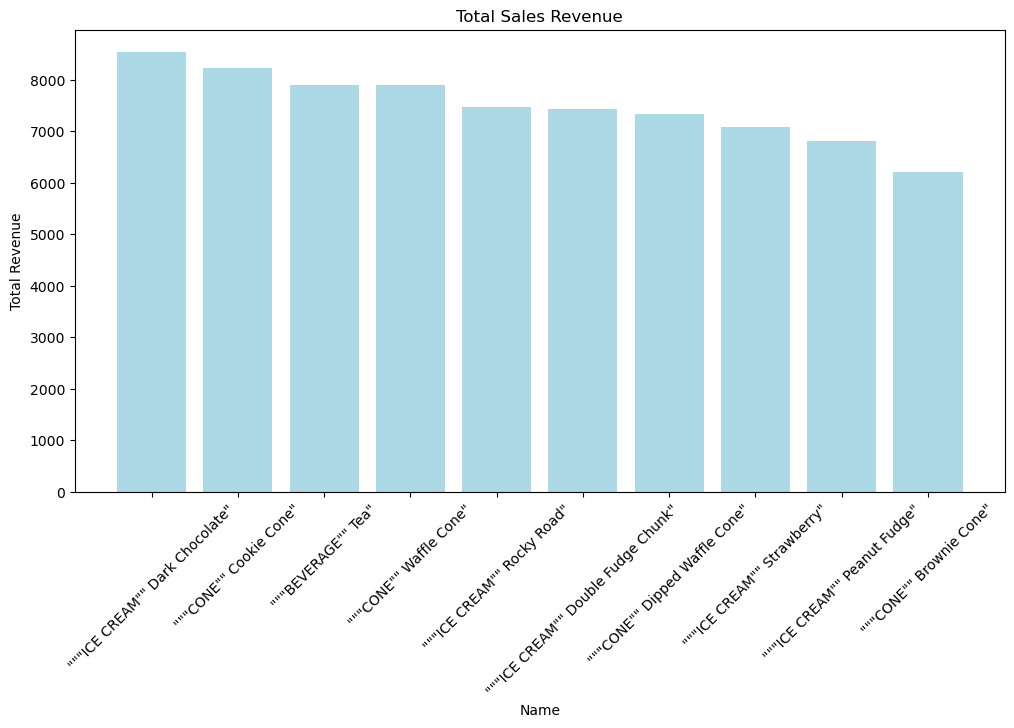

In [14]:
products = top_10_summary.select("name").rdd.flatMap(lambda x: x).collect()
revenues = top_10_summary.select("total_revenue").rdd.flatMap(lambda x: x).collect()

# Generate a bar chart to visualize total revenue by product, for top 10 sales
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(products, revenues, color='lightblue')
plt.xlabel("Name")
plt.ylabel("Total Revenue")
plt.title("Total Sales Revenue")
plt.xticks(rotation=45)
plt.show()